In [150]:
import time
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.stats import qmc
import random
from datetime import datetime
from IPython.display import HTML, display, Latex

In [151]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [152]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [153]:
tf.keras.backend.set_floatx("float64")

In [154]:
class Heat2DPINN():
    def __init__(self, input_shape=1, out_shape=1, layers=[10, 10, 10], activation='tanh', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), alpha=1):
        super(Heat2DPINN, self).__init__()
        self.optimizer = optimizer
        self.model = self.build(input_shape, out_shape, layers, activation)
        self.alpha = alpha

    def build(self, input_shape, output_shape, layers, activation):
        input_layer = tf.keras.layers.Input(shape=(input_shape,))
        kernel_initializer=tf.keras.initializers.GlorotNormal(seed=177013)

        hidden = [tf.keras.layers.Dense(layers[0], activation=activation)(input_layer)]
        for i in range(1, len(layers)):
            new_layer = tf.keras.layers.Dense(
                    layers[i],
                    activation=activation,
                    activity_regularizer=None
                )(hidden[-1])
            hidden.append(new_layer)

        output_layer = tf.keras.layers.Dense(output_shape, activation=None)(hidden[-1])

        name = f"DNN-{len(layers)}"
        model = tf.keras.Model(input_layer, output_layer, name=name)
        model.summary()
    
        return model
    
    def save_model(self, file_path):
        self.model.save(file_path)
        print(f"Model saved to {file_path}.")

    def save_weights(self, file_path):
        self.model.save_weights(file_path)
        print(f"Weights saved to {file_path}.")

    def load_model(self, file_path):
        self.model = tf.keras.models.load_model(file_path)
        print(f"Model loaded from {file_path}.")

    def load_weights(self, file_path):
        self.model.load_weights(file_path)
        print(f"Weights loaded from {file_path}.")

    @tf.function
    def dirichlet_condition(self, x1_bc, x2_bc, t_bc, u_bc):
        x1_x2_t = tf.concat([x1_bc, x2_bc, t_bc], axis=1)
        u = self.model(x1_x2_t)
        return tf.reduce_mean(tf.square(u - u_bc))

    @tf.function
    def neuman_condition(self, x1_x2_bc_right):
        _, u_x1, _,  _, _ = self.forward(x1_x2_bc_right)
        return tf.reduce_mean(tf.square(u_x1))

    @tf.function
    def loss_fn(self, x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc):
        x1_x2_t = tf.concat([x1_in, x2_in, t_in], axis=1)
        u0 = self.model(x1_x2_t)
        u_x1 = tf.gradients(u0, x1_in)[0]
        u_x2 = tf.gradients(u0, x2_in)[0]
        u_t = tf.gradients(u0, t_in)[0]
        u_x1x1 = tf.gradients(u_x1, x1_in)[0]
        u_x2x2 = tf.gradients(u_x2, x2_in)[0]
        heat_eq = u_t - self.alpha * (u_x1x1 - u_x2x2)
        bc_dirichlet = self.dirichlet_condition(x1_bc, x2_bc, t_bc, u_bc)

        return tf.reduce_mean(tf.square(heat_eq)) + 40 * bc_dirichlet
    
    def train(self, loss_threshold, x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc):
        loss_array = []
        best_loss = math.inf
        start_time = time.time()

        loss = tf.constant(float('inf'))
        epoch = 0
        try:
            while loss.numpy() > loss_threshold:
                with tf.GradientTape() as tape:
                    loss = self.loss_fn(x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                if (best_loss > loss.numpy()):
                    best_loss = loss.numpy()

                loss_array.append(loss)
                if epoch % 100 == 0:
                    print(f'Epoch {epoch}, Loss: {loss.numpy()}, Min loss: {best_loss}')
                epoch += 1
        except KeyboardInterrupt:
            print("Training stopped manually")

        elapsed_time = time.time() - start_time
        minutes = int(elapsed_time // 60)
        seconds = int(elapsed_time % 60)
        print("Training took %d minutes and %d seconds" % (minutes, seconds))
        print(f"Last epoch: {epoch}, loss: {loss.numpy()}")
        print(f"Best epoch: {np.argmin(loss_array)}, loss: {min(loss_array)}")

        plt.plot(loss_array)
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат')
        plt.savefig("1d_nonstationary_heat_equation_training.png")
        plt.show(block=False)

        start_epoch = 1000
        end_epoch = 3000

        end_epoch = min(end_epoch, len(loss_array) - 1)

        plt.plot(range(start_epoch, end_epoch + 1), loss_array[start_epoch:end_epoch + 1])
        plt.xlabel('Епоха')
        plt.ylabel('Втрати')
        plt.grid()
        plt.title('Значення втрат від 1000 до 3000 епохи')
        plt.show(block=False)

In [155]:
N_of_train_points_2D = 141
N_of_test_points_2D = 100
N_of_fem_points_2D = 30
N_of_time_steps = 100
L_x1 = 0.0
R_x1 = 1.0
L_x2 = 0.0
R_x2 = 1.0
L_t = 0.0
R_t = 2.0
Dirichlet_up_2D = 0.0
Dirichlet_down_2D = 0.0
loss_threshold_2D = 2.5e-1
Layers_2D = [50, 50, 50, 50, 50, 50, 50, 50, 50, 50]
Learning_rate_2D = 5e-4
alpha = 0.01
Optimizer_2D = tf.keras.optimizers.Adam(learning_rate=Learning_rate_2D)

In [156]:
model_2D = Heat2DPINN(3, 1, Layers_2D, 'tanh', Optimizer_2D, alpha)
# tf.keras.utils.plot_model(model_2D.model, to_file='model_plot.png', show_shapes=True, 
#                           show_layer_names=True, show_dtype=True, 
#                           show_layer_activations=True)

Model: "DNN-10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_99 (Dense)            (None, 50)                200       
                                                                 
 dense_100 (Dense)           (None, 50)                2550      
                                                                 
 dense_101 (Dense)           (None, 50)                2550      
                                                                 
 dense_102 (Dense)           (None, 50)                2550      
                                                                 
 dense_103 (Dense)           (None, 50)                2550      
                                                                 
 dense_104 (Dense)           (None, 50)                2550 

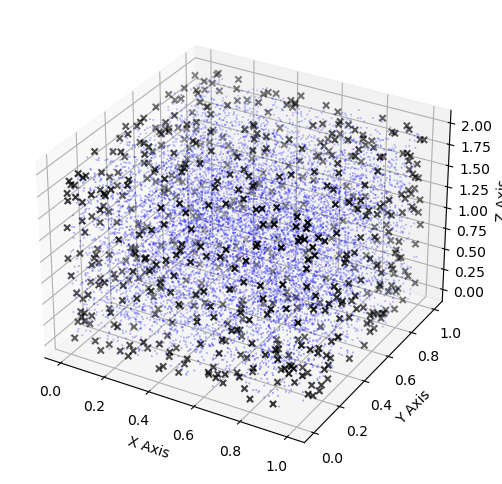

In [157]:
n_bc = 6
n_data_per_bc = 100
Nc = 10000

engine = qmc.LatinHypercube(d=2)
data = np.zeros([n_bc, n_data_per_bc, 4])

for i in range(n_bc):
    if i < 2:
        points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1, L_t], [R_x1, R_t])
        if i == 0:
            data[i, :, 0] = L_x1
            data[i, :, 1:3] = points
        else:
            data[i, :, 0] = R_x1
            data[i, :, 1:3] = points
    elif i < 4:
        points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1, L_t], [R_x1, R_t])
        if i == 2:
            data[i, :, 0] = points[:, 0]
            data[i, :, 1] = L_x2
            data[i, :, 2] = points[:, 1]
        else:
            data[i, :, 0] = points[:, 0]
            data[i, :, 1] = R_x2
            data[i, :, 2] = points[:, 1]
    else:
        points = qmc.scale(engine.random(n=n_data_per_bc), [L_x1, L_x2], [R_x1, R_x2])
        if i == 4:
            data[i, :, 0] = points[:, 0]
            data[i, :, 1] = points[:, 1]
            data[i, :, 2] = L_t
        else:
            data[i, :, 0] = points[:, 0] 
            data[i, :, 1] = points[:, 1]
            data[i, :, 2] = R_t

data[0, :, 3] = 0.0
data[1, :, 3] = 0.0
data[2, :, 3] = 0.0
data[3, :, 3] = 1.0
data[4, :, 3] = 0

data = data.reshape(n_data_per_bc * n_bc, 4)

x1_bc, x2_bc, t_bc, u_bc = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3]])

engine = qmc.LatinHypercube(d=3)
colloc = qmc.scale(engine.random(n=Nc), [L_x1, L_x2, L_t], [R_x1, R_x2, R_t])

x1_in, x2_in, t_in = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1], colloc[:, 2]])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
#ax.title("Boundary Data points and Internal points")
ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker="x", c="k", label="BDP")
ax.scatter(colloc[:, 0], colloc[:, 1], colloc[:, 2], s=.2, marker=".", c="b", label="CP")
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('t')
plt.show()

x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc = map(
    lambda x: tf.convert_to_tensor(x, dtype=tf.float64),
    [x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc]
)

2024-05-16 11:54:58.306914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_23' with dtype int32
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_23}}]]


Epoch 0, Loss: 5.805446503787589, Min loss: 5.805446503787589
Epoch 100, Loss: 1.5707977474412933, Min loss: 1.5707977474412933
Epoch 200, Loss: 0.6960218271381631, Min loss: 0.6815166759629716
Epoch 300, Loss: 0.6076497579885791, Min loss: 0.5980467296358642
Epoch 400, Loss: 0.6062244031355847, Min loss: 0.584919681449219
Epoch 500, Loss: 0.5819629630450591, Min loss: 0.5785664685990104
Epoch 600, Loss: 0.5816186219484608, Min loss: 0.5725685517924247
Epoch 700, Loss: 0.6187926951583096, Min loss: 0.5689048440821458
Epoch 800, Loss: 0.5683808308391181, Min loss: 0.5651079617790963
Epoch 900, Loss: 0.5815352896046606, Min loss: 0.5613718146554703
Epoch 1000, Loss: 0.5606916217195499, Min loss: 0.5576193341568384
Epoch 1100, Loss: 0.5623518644478693, Min loss: 0.5539570837430904
Epoch 1200, Loss: 0.5769826354783553, Min loss: 0.5491905550554886
Epoch 1300, Loss: 0.5350888895954744, Min loss: 0.5350888895954744
Epoch 1400, Loss: 0.5358132466442882, Min loss: 0.5137029111964362
Epoch 1500

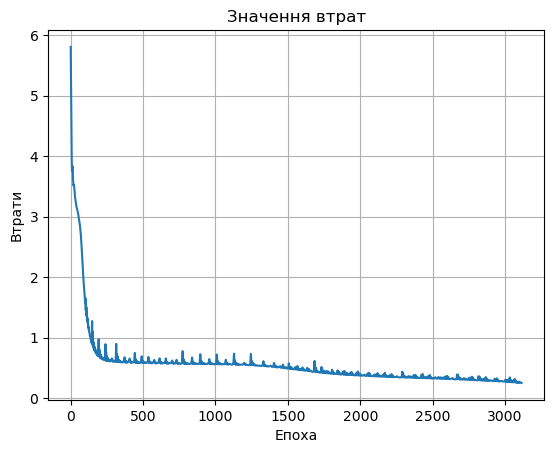

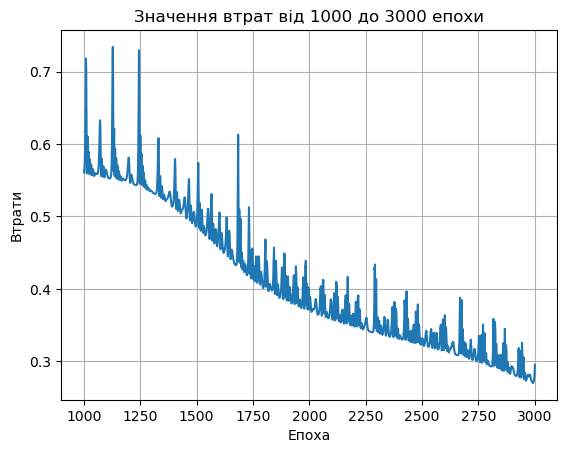

In [158]:
model_2D.train(loss_threshold_2D, x1_in, x2_in, t_in, x1_bc, x2_bc, t_bc, u_bc)

In [159]:
x1_test = np.linspace(L_x1, R_x1, N_of_test_points_2D)[:, np.newaxis]
x2_test = np.linspace(L_x2, R_x2, N_of_test_points_2D)[:, np.newaxis]
t_test = np.linspace(L_t, R_t, N_of_time_steps)[:, np.newaxis]
x1_mesh, x2_mesh = np.meshgrid(x1_test, x2_test)

x1_flat = np.repeat(x1_mesh.flatten()[:, np.newaxis], N_of_test_points_2D, axis=0)
x2_flat = np.repeat(x2_mesh.flatten()[:, np.newaxis], N_of_test_points_2D, axis=0)
t_flat = np.tile(t_test, (x1_mesh.size, 1))

test_input = np.hstack((x1_flat, x2_flat, t_flat))

u_pinn = model_2D.model(test_input).numpy()

u_pinn = u_pinn.reshape(N_of_test_points_2D, N_of_test_points_2D, N_of_test_points_2D)

In [160]:
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111, projection='3d')


# surf = ax.plot_surface(x1_mesh, x2_mesh, u_pinn[:, :, 0], cmap='viridis', linewidth=0, antialiased=False)


# ax.set_xlabel('x_2')
# ax.set_ylabel('x_1')
# ax.set_zlabel('u')
# ax.set_title('PINN Solution for 2D Nonstationary Heat Equation')


# ax.set_zlim(u_pinn.min(), u_pinn.max())


# def update(frame):
#     ax.clear()
#     ax.plot_surface(x1_mesh, x2_mesh, u_pinn[:, :, frame], cmap='viridis', linewidth=0, antialiased=False)
#     ax.set_xlabel('x_2')
#     ax.set_ylabel('x_1')
#     ax.set_zlabel('u')
#     ax.set_title('PINN Solution at t={:.2f}'.format(t_test[frame][0]))
#     ax.set_zlim(u_pinn.min(), u_pinn.max())


# ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)


# #ani.save('2d_nonstationary_heat_pinn_solution.mp4', writer='ffmpeg', fps=10)
# ani.save('2d_nonstationary_heat_pinn_solution.gif', writer=PillowWriter(fps=10))

# plt.close()


In [161]:
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(u_pinn[:, :, 0], extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

fig.colorbar(cax, ax=ax)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
title = ax.set_title('PINN Solution at t=0')

def update(frame):
    cax.set_data(u_pinn[:, :, -frame])
    #print(frame)
    title.set_text('Розв\'язок, отриманий за допомогою PINN при t={:.2f}'.format(t_test[frame][0]))

ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)

ani.save('2d_nonstationary_heat_pinn_solution_heatmap.gif', writer=PillowWriter(fps=10))

plt.close()


random_int = random.randint(0, int(2e9))
current_time = datetime.now().strftime("%Y%m%d%H%M%S")
__counter__ = f"{current_time}{random_int}"

url = f"2d_nonstationary_heat_pinn_solution_heatmap.gif?{__counter__}"
html = f'<img src="{url}" alt="PINN Solution">'
display(HTML(html))


In [162]:
from fenics import *

dt = (R_t - L_t) / N_of_time_steps
alpha = 0.01

mesh = RectangleMesh(Point(L_x1, L_x2), Point(R_x1, R_x2), N_of_fem_points_2D-1, N_of_fem_points_2D-1)
V = FunctionSpace(mesh, 'P', 1)

fine_mesh = RectangleMesh(Point(L_x1, L_x2), Point(R_x1, R_x2), N_of_test_points_2D-1, N_of_test_points_2D-1)
V_fine = FunctionSpace(fine_mesh, 'P', 1)

boundary_conditions = [
    DirichletBC(V, Constant(0), f"on_boundary && !near(x[1], {R_x2})"),
    DirichletBC(V, Constant(1), f"on_boundary && near(x[1], {R_x2})")
]

u_n = interpolate(Constant(0), V)

u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

# Implicit Euler
# F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx

# Midpoint (Crank-Nicolson)
u_mid = 0.5*(u_n + u)
F = (u - u_n)*v*dx + dt*alpha*dot(grad(u_mid), grad(v))*dx - dt*f*v*dx
a, L = lhs(F), rhs(F)


u = Function(V)
u_fem = []

for n in range(N_of_time_steps):
    t = n*dt

    solve(a == L, u, boundary_conditions)
    u_n.assign(u)

    u_fine = interpolate(u, V_fine)
    
    u_fem.append(u_fine.compute_vertex_values(fine_mesh).reshape((N_of_test_points_2D, N_of_test_points_2D)))

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

In [163]:
def calculate_max_relative_error(u_pred, u_exact):
    u_pred_flat = u_pred.flatten()
    u_exact_flat = u_exact.flatten()
    return 100 * np.linalg.norm(u_exact_flat - u_pred_flat, np.inf) / np.linalg.norm(u_exact_flat, np.inf)

In [164]:
def relative_l2_norm_error(u_pred, u_true):
    u_pred_flat = u_pred.flatten()
    u_true_flat = u_true.flatten()
    error_norm = np.linalg.norm(u_true_flat - u_pred_flat)
    true_norm = np.linalg.norm(u_true_flat)
    return 100 * error_norm / true_norm

In [165]:
u_pinn = np.transpose(u_pinn, (2, 0, 1))

In [166]:

def compute_errors(u_pinn_values, u_fem_values):
    mse_error = np.mean((u_fem_values - u_pinn_values)**2)
    print(f"Mean Squared Error (PINN and FEM): {mse_error:.3}")
    relative_error = calculate_max_relative_error(np.array(u_fem_values), np.array(u_pinn_values))
    display(Latex(f"Relative $l^{{\\infty}}$ error (PINN and FEM): {relative_error:.3}%"))
    relative_l2_error = relative_l2_norm_error(np.array(u_fem_values), np.array(u_pinn_values))
    display(Latex(f"Relative $l^{2}$ error (PINN and FEM): {relative_l2_error:.3}%"))

In [167]:
compute_errors(u_pinn, u_fem)

Mean Squared Error (PINN and FEM): 0.0117


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [168]:
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(u_fem[0].T, extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

fig.colorbar(cax, ax=ax)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
title = ax.set_title('FEM at t=0')

def update(frame):
    cax.set_array(u_fem[frame])
    title.set_text('FEM at t={:.2f}'.format(t_test[frame][0]))
ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)

#ani.save('2d_nonstationary_heat_pinn_solution_heatmap.mp4', writer=PillowWriter(fps=10))
ani.save('2d_nonstationary_heat_fem_heatmap.gif', writer=PillowWriter(fps=10))

plt.close()

random_int = random.randint(0, int(2e9))

current_time = datetime.now().strftime("%Y%m%d%H%M%S")

__counter__ = f"{current_time}{random_int}"

url = f"2d_nonstationary_heat_fem_heatmap.gif?{__counter__}"
html = f'<img src="{url}" alt="PINN Solution">'
display(HTML(html))

In [169]:
max_absolute_difference = np.max(np.abs(u_fem - u_pinn))
print(f"Maximum Absolute Difference (PINN and FEM): {max_absolute_difference}")


Maximum Absolute Difference (PINN and FEM): 1.0165058707744705


In [170]:
fig, ax = plt.subplots(figsize=(8, 6))

err = np.abs(np.array(u_fem) - u_pinn)

cax = ax.imshow(err[:, :, 0], extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')

fig.colorbar(cax, ax=ax)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
title = ax.set_title('Похибка при t=0')

def update(frame):
    cax.set_data(err[:, :, -frame].T)
    title.set_text('Похибка при t={:.2f}'.format(t_test[frame][0]))

ani = FuncAnimation(fig, update, frames=range(N_of_test_points_2D), blit=False)

#ani.save('2d_nonstationary_heat_pinn_solution_heatmap.mp4', writer=PillowWriter(fps=10))
ani.save('2d_nonstationary_heat_pinn_error_heatmap.gif', writer=PillowWriter(fps=10))

plt.close()

random_int = random.randint(0, int(2e9))

current_time = datetime.now().strftime("%Y%m%d%H%M%S")

__counter__ = f"{current_time}{random_int}"

url = f"2d_nonstationary_heat_pinn_error_heatmap.gif?{__counter__}"
html = f'<img src="{url}" alt="PINN Solution">'
display(HTML(html))

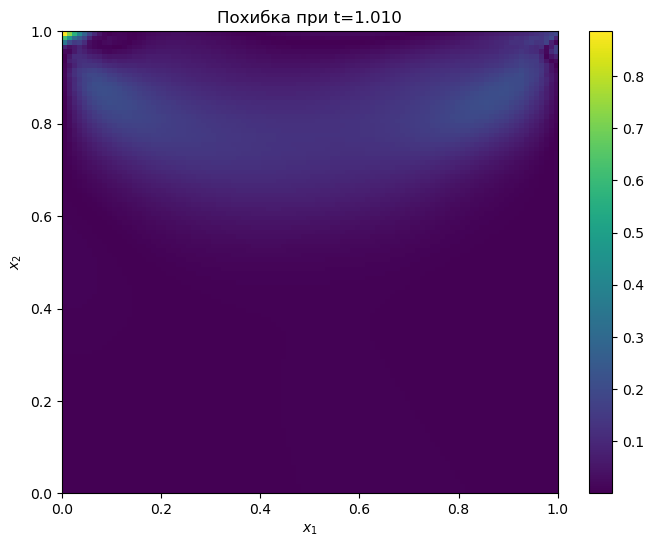

Mean Squared Error (PINN and FEM): 0.00474


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))
frame_num = 50
err = np.abs(np.array(u_fem[frame_num]) - np.array(u_pinn[frame_num]))

cax = ax.imshow(err, extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')
fig.colorbar(cax, ax=ax)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
title = ax.set_title(f'Похибка при t={t_test[frame_num][0]:.3f}')
plt.show()

compute_errors(u_pinn[frame_num], u_fem[frame_num])


In [177]:
def get_PINN_plot_at_t(frame_num):
    fig, ax = plt.subplots(figsize=(8, 6))
    err = np.abs(np.array(np.array(u_pinn[frame_num])))

    cax = ax.imshow(err, extent=[L_x1, R_x1, L_x2, R_x2], origin='lower', cmap='viridis', aspect='auto')
    fig.colorbar(cax, ax=ax)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('$u_{PINN}$'+f" при t={t_test[frame_num][0]:.3f}")
    plt.show()

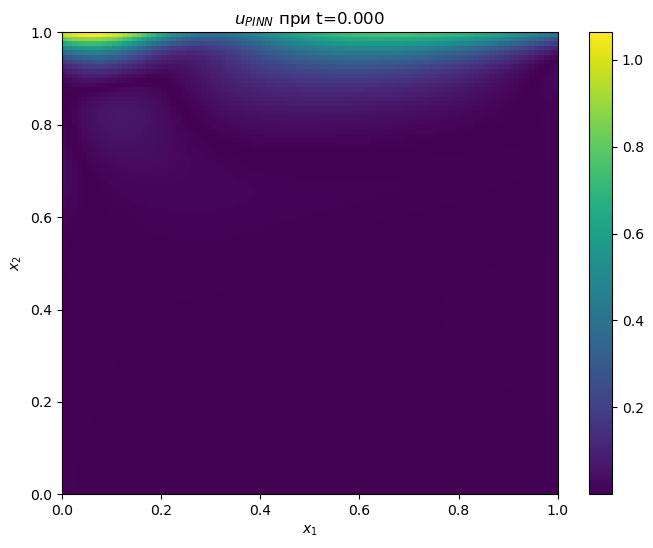

Mean Squared Error (PINN and FEM): 0.00648


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [179]:
frame_num = 0
get_PINN_plot_at_t(frame_num)
compute_errors(u_pinn[frame_num], u_fem[frame_num])


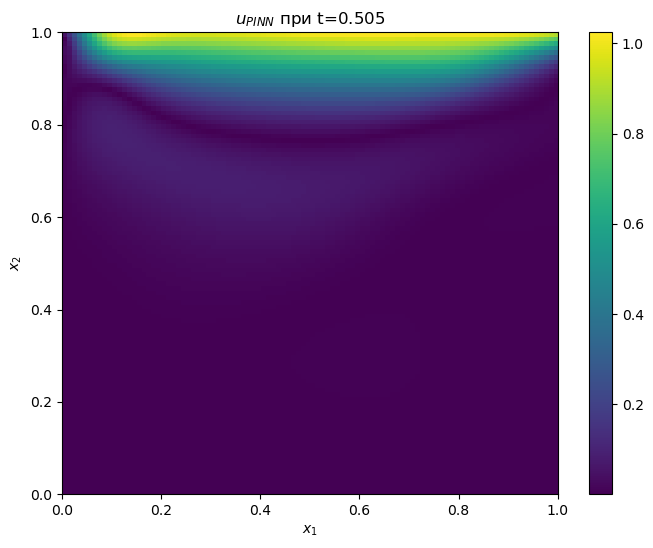

Mean Squared Error (PINN and FEM): 0.00254


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [180]:
frame_num = 25
get_PINN_plot_at_t(frame_num)
compute_errors(u_pinn[frame_num], u_fem[frame_num])

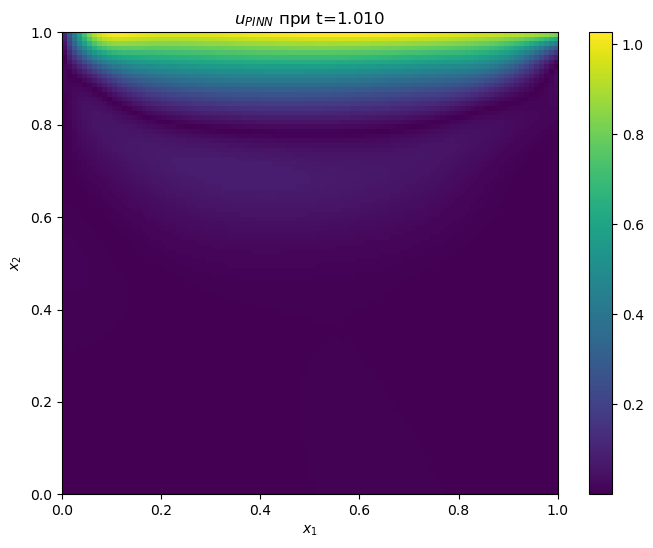

Mean Squared Error (PINN and FEM): 0.00474


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [181]:
frame_num = 50
get_PINN_plot_at_t(frame_num)
compute_errors(u_pinn[frame_num], u_fem[frame_num])

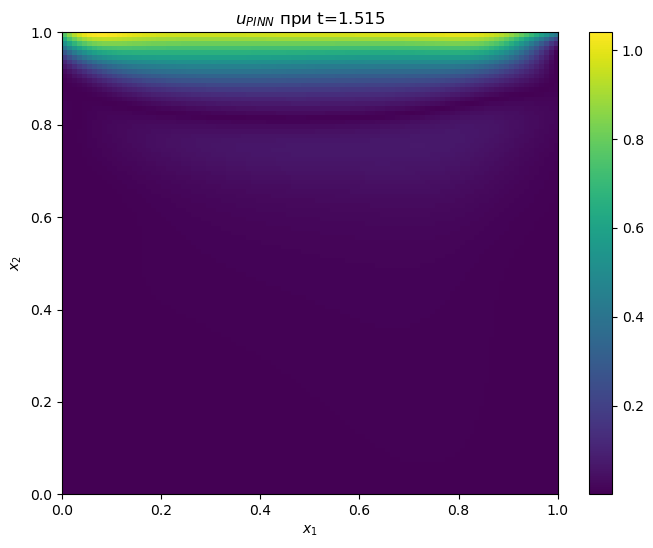

Mean Squared Error (PINN and FEM): 0.0154


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [186]:
frame_num = 75
get_PINN_plot_at_t(frame_num)
compute_errors(u_pinn[frame_num], u_fem[frame_num])

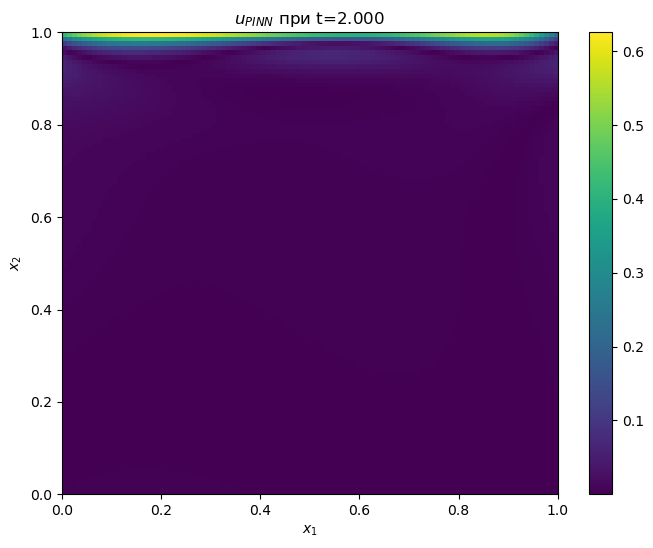

Mean Squared Error (PINN and FEM): 0.0673


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [184]:
frame_num = 99
get_PINN_plot_at_t(frame_num)
compute_errors(u_pinn[frame_num], u_fem[frame_num])